# install jdk and spark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Compare quetion with database questions

In [3]:
#make doc_mag.txt into a list of tuples (docid,maxf,magnitudes)
doc_mag_text=open( "/content/drive/My Drive/doc_mag.txt","r")

doc_mag_lines=doc_mag_text.readlines()
doc_mag_lines = list(map(eval, doc_mag_lines))
doc_mag_lines = list(map(lambda x : (x[0],x[1][0],x[1][1]),doc_mag_lines))

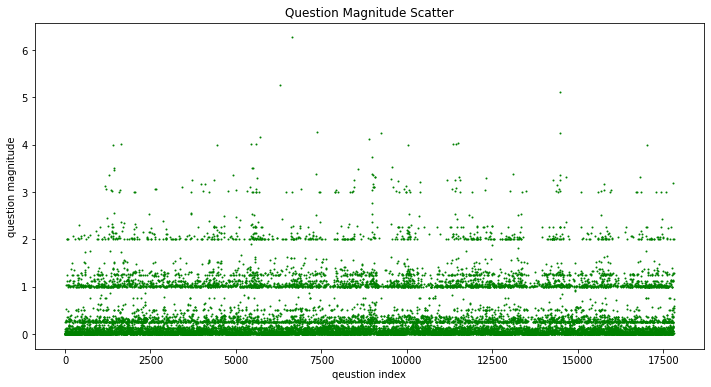

In [66]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 6))
plt.scatter(list(map(lambda x : (x[0]),doc_mag_lines)), list(map(lambda x : (x[2]),doc_mag_lines)), color ='g', s=1)
plt.xlabel('qeustion index')
plt.ylabel('question magnitude')
plt.title('Question Magnitude Scatter')
plt.show()
fig.savefig('question_magnitude_scatter.png', dpi=fig.dpi)

In [33]:
#make inv_idx.txt into a list of tuples (word,[(docid,freq,tfidf),...)
posting_text=open( "/content/drive/My Drive/inv_idx.txt","r") 
posting_lines = posting_text.readlines()
posting_lines = list(map(eval, posting_lines))
posting_lines = list( map(lambda x: (x[0], str(x[1])), posting_lines) )
print(posting_lines)

Output hidden; open in https://colab.research.google.com to view.

In [67]:
word0_name = list( map(lambda x: (x[0]), posting_lines) )[1]
word0 = list( map(lambda x: (x[1]), posting_lines) )[1]

In [68]:
#Creating database tables and inserting the values from text files into these tables
import sqlite3
conn1 = sqlite3.connect('docmag.db')
c1 = conn1.cursor()
c1.execute("""CREATE TABLE IF NOT EXISTS docmag (
             docid integer PRIMARY KEY,
             maxf integer,
             mag float)
         """)
#Creating Index using B-TREE on docid coloumn of DocMag table
c1.execute("""CREATE UNIQUE INDEX idx_docmag_docid ON docmag (docid)""")
c1.executemany("INSERT or replace INTO docmag VAlUES (?,?,?)", doc_mag_lines)
conn1.commit()
c1.execute("SELECT * FROM docmag")
print(c1.fetchone())

conn = sqlite3.connect('posting.db')
c = conn.cursor()
c.execute("""CREATE TABLE IF NOT EXISTS posting (
             word VARCHAR(100) PRIMARY KEY,
             postinglist_freq_tfidf text)
         """)
#Creating Index using B-TREE on word coloumn of Posting table
c.execute("""CREATE UNIQUE INDEX idx_Posting_word ON posting (word)""")
c.executemany("INSERT or replace INTO posting VAlUES (?,?)", posting_lines)
conn.commit()
c.execute("SELECT * FROM posting")
print(c.fetchone())

(0, 1, 0.008883302569933728)
('solo', '[(15, 1, 0.058823529411764705), (10, 1, 0.058823529411764705), (14, 1, 0.058823529411764705), (2, 1, 0.058823529411764705), (12, 1, 0.058823529411764705), (125, 1, 0.058823529411764705), (130, 1, 0.058823529411764705), (135, 1, 0.058823529411764705), (134, 1, 0.058823529411764705), (131, 1, 0.058823529411764705), (23, 1, 0.058823529411764705), (4764, 1, 0.058823529411764705), (4725, 1, 0.058823529411764705), (15163, 1, 0.058823529411764705), (14131, 1, 0.058823529411764705), (227, 1, 0.058823529411764705), (615, 1, 0.058823529411764705)]')


In [69]:
res = conn1.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res.fetchall():
    print(name[0])

docmag


In [70]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [71]:
from bs4 import BeautifulSoup
from collections import Counter
import re
from nltk.corpus import stopwords
import math

dictOfDocuments={}
magOfQuery=0
word_TF = [('feb', 0.5), ('fantistic', 0.5), ('morning', 1.0), ('good', 0.5)]
for i in range(len(word_TF)):
  c.execute("SELECT postinglist_freq_tfidf FROM Posting where word='"+word_TF[i][0]+"'")
  text=c.fetchone()
  if text!=None:
    postinglist_freq_tfidf=eval(text[0])
    tfIdf=word_TF[i][1]/len(postinglist_freq_tfidf)
    magOfQuery=magOfQuery+(tfIdf*tfIdf)

    for j in range(len(postinglist_freq_tfidf)):
      
      if postinglist_freq_tfidf[j][0] in dictOfDocuments:
        
        dictOfDocuments[postinglist_freq_tfidf[j][0]] = tfIdf*float(postinglist_freq_tfidf[j][2])+ dictOfDocuments[postinglist_freq_tfidf[j][0]]
      else:
        dictOfDocuments[postinglist_freq_tfidf[j][0]]= tfIdf*float(postinglist_freq_tfidf[j][2])
print(dictOfDocuments)

{11193: 1.0, 4700: 0.0013850415512465372, 4970: 0.0013850415512465372, 4968: 0.0013850415512465372, 4971: 0.0013850415512465372, 4969: 0.0013850415512465372, 5696: 0.0013850415512465372, 17215: 0.0013850415512465372, 16611: 0.0013850415512465372, 14815: 0.0006925207756232686, 14820: 0.0013850415512465372, 14907: 0.0013850415512465372, 14912: 0.0013850415512465372, 11347: 0.0013850415512465372, 9550: 0.0013850415512465372, 7863: 0.0013850415512465372, 7262: 0.0013850415512465372, 7264: 0.0013850415512465372, 6764: 0.0013850415512465372, 4655: 0.0013850415512465372}


# Find best match question index

In [75]:
from bs4 import BeautifulSoup
from collections import Counter
import re
from nltk.corpus import stopwords
import math
stop_words = set(stopwords.words('english'))
# for a given query, we retutn a list of tuples of the form (w,freq/maxfreq)
# the same strp as part1
def dw(query):
  words = re.findall('[a-zA-Z]+', query)
  words = [w.lower() for w in words]  
  words = [w for w in words if not w in stop_words]
  # Counter({'morning': 2, 'feb': 1, 'fantistic': 1, 'good': 1})
  counter = Counter(words)
  # morning    2
  most_common,maxf = counter.most_common(1)[0]
  # [('feb', 0.5), ('fantistic', 0.5), ('morning', 1.0), ('good', 0.5)]
  word_TF = [(w,counter[w]/maxf) for w in counter]

  dictOfDocuments={}
  magOfQuery=0
  # Calculating Cosine silimarity of each document with the query
  for i in range(len(word_TF)):
    c.execute("SELECT postinglist_freq_tfidf FROM Posting where word='"+word_TF[i][0]+"'")
    text=c.fetchone()
    if text!=None:
      postinglist_freq_tfidf=eval(text[0])
      tfIdf=word_TF[i][1]/len(postinglist_freq_tfidf)
      magOfQuery=magOfQuery+(tfIdf*tfIdf)
      for j in range(len(postinglist_freq_tfidf)):
        if postinglist_freq_tfidf[j][0] in dictOfDocuments:
          dictOfDocuments[postinglist_freq_tfidf[j][0]] = tfIdf*float(postinglist_freq_tfidf[j][2])+ dictOfDocuments[postinglist_freq_tfidf[j][0]]
        else:
          dictOfDocuments[postinglist_freq_tfidf[j][0]]= tfIdf*float(postinglist_freq_tfidf[j][2])

  for docId in dictOfDocuments:
    c1.execute("SELECT mag FROM docmag where docid= ?",(docId,))
    dictOfDocuments[docId]=dictOfDocuments[docId]/(math.sqrt(c1.fetchone()[0])*math.sqrt(magOfQuery))

  # Sorting and printing the documents in a reverse order acording to Cosine similarity with the query
  sortedListofTuples = sorted(dictOfDocuments.items() , reverse=True, key=lambda x: x[1])
  print('Reuslt:')
  if len(sortedListofTuples)==0:
    print('We could not find your words.')
  else:
    print('did     :', '  Cosine Similarity')
  row = "{did:<7s} :   {cosine}".format
  
  count = 0
  for elem in sortedListofTuples :
    
    print(row(did='d'+str(elem[0]), cosine=elem[1]))
    count += 1 
    if count == 10:
      break
  return sortedListofTuples[0][0]

In [ ]:

import ipywidgets as widgets
from ipywidgets import Textarea, Button, Output
from IPython.display import display


def on_button_clicked(b):
    with output:
      dw(textarea.value)


textarea = Textarea(
    placeholder='Please enter your keywords here',
    disabled=False
)

button = Button(
    description='Search',
    disabled=False,
)
output = Output()
      
button.on_click(on_button_clicked)
display(textarea, button, output)

Textarea(value='', placeholder='Please enter your keywords here')

Button(description='Search', style=ButtonStyle())

Output()

In [ ]:
input = 'When did Beyonce start becoming popular?'
output_index = dw(input)

Reuslt:
did     :   Cosine Similarity
d0      :   1.0
d9617   :   0.9233077033753426
d3598   :   0.8684228421972422
d15070  :   0.5248378352786544
d4743   :   0.39604369855101873
d14572  :   0.3947155727468949
d12762  :   0.39250264561495385
d12117  :   0.38727336227813886
d3828   :   0.16586125667205892
d15075  :   0.16537213408379695


In [ ]:
output_index

0

# Slimilarity plot

In [80]:

def dw_plot(query):
  words = re.findall('[a-zA-Z]+', query)
  words = [w.lower() for w in words]
  words = [w for w in words if not w in stop_words]
  counter = Counter(words)
  most_common,maxf = counter.most_common(1)[0]
  word_TF = [(w,counter[w]/maxf) for w in counter]

  dictOfDocuments={}
  magOfQuery=0
  # Calculating Cosine silimarity of each document with the query
  for i in range(len(word_TF)):
    c.execute("SELECT postinglist_freq_tfidf FROM Posting where word='"+word_TF[i][0]+"'")
    text=c.fetchone()
    if text!=None:
      postinglist_freq_tfidf=eval(text[0])
      tfIdf=word_TF[i][1]/len(postinglist_freq_tfidf)
      magOfQuery=magOfQuery+(tfIdf*tfIdf)
      for j in range(len(postinglist_freq_tfidf)):
        if postinglist_freq_tfidf[j][0] in dictOfDocuments:
          dictOfDocuments[postinglist_freq_tfidf[j][0]] = tfIdf*float(postinglist_freq_tfidf[j][2])+ dictOfDocuments[postinglist_freq_tfidf[j][0]]
        else:
          dictOfDocuments[postinglist_freq_tfidf[j][0]]= tfIdf*float(postinglist_freq_tfidf[j][2])

  for docId in dictOfDocuments:
    c1.execute("SELECT mag FROM docmag where docid= ?",(docId,))
    dictOfDocuments[docId]=dictOfDocuments[docId]/(math.sqrt(c1.fetchone()[0])*math.sqrt(magOfQuery))
  # Sorting and printing the documents in a reverse order acording to Cosine similarity with the query
  sortedListofTuples = sorted(dictOfDocuments.items() , reverse=True, key=lambda x: x[1])
  # print('Reuslt:')
  # if len(sortedListofTuples)==0:
  #   print('We could not find your words.')
  # else:
  #   print('did     :', '  Cosine Similarity')
  # row = "{did:<7s} :   {cosine}".format
  
  # count = 0
  # for elem in sortedListofTuples :
    
  #   print(row(did='d'+str(elem[0]), cosine=elem[1]))
  #   count += 1 
  #   if count == 10:
  #    break
  return sortedListofTuples

In [115]:
a = dw_plot('When did Beyonce become very famous?	')

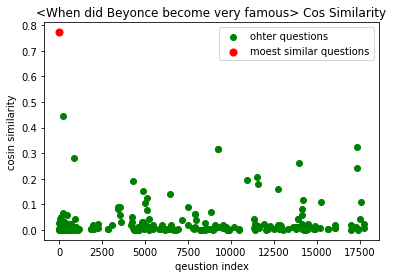

In [119]:
fig = plt.figure()
plt.scatter(list(map(lambda x : (x[0]),a)), list(map(lambda x : (x[1]),a)), color ='g')
plt.scatter(list(map(lambda x : (x[0]),a))[np.argmax(list(map(lambda x : (x[1]),a)))], 
            max(list(map(lambda x : (x[1]),a))), color ='r', s=50)
plt.legend({'ohter questions', 'moest similar questions'})
plt.xlabel('qeustion index')
plt.ylabel('cosin similarity')
plt.title('<When did Beyonce become very famous> Cos Similarity')
plt.show()
fig.savefig('cos_similarity1.png', dpi=fig.dpi)

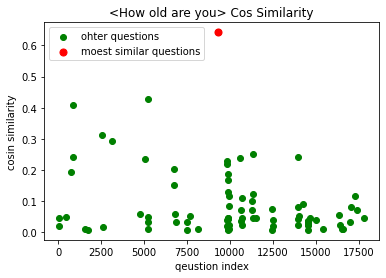

In [123]:
a = dw_plot('How old are you?')
fig = plt.figure()
plt.scatter(list(map(lambda x : (x[0]),a)), list(map(lambda x : (x[1]),a)), color ='g')
plt.scatter(list(map(lambda x : (x[0]),a))[np.argmax(list(map(lambda x : (x[1]),a)))], 
            max(list(map(lambda x : (x[1]),a))), color ='r', s=50)
plt.legend({'ohter questions', 'moest similar questions'}, loc=2)
plt.xlabel('qeustion index')
plt.ylabel('cosin similarity')
plt.title('<How old are you> Cos Similarity')
plt.show()
fig.savefig('cos_similarity2.png', dpi=fig.dpi)

# Load QC pair generated before

In [ ]:
import pandas as pd

qc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSC503/data/qc.csv')

In [ ]:
qc.head()

,Unnamed: 0,question,context
0,0,When did Beyonce start becoming popular?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
1,1,What areas did Beyonce compete in when she was...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
2,2,When did Beyonce leave Destiny's Child and bec...,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
3,3,In what city and state did Beyonce grow up?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...
4,4,In which decade did Beyonce become famous?,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...


# Load fine-tuned bert model trained before

In [ ]:
!pip install transformers
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFBertModel
from tokenizers import BertWordPieceTokenizer

     |████████████████████████████████| 2.5MB 19.6MB/s 
     |████████████████████████████████| 3.3MB 28.9MB/s 
     |████████████████████████████████| 901kB 35.4MB/s 


In [ ]:
model =keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/save/model.h5')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


# Model test


In [ ]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
tokenizer = BertWordPieceTokenizer("bert-base-uncased-vocab.txt", lowercase=True)

--2021-07-15 06:53:27--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.165.64
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.165.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231508 (226K) [text/plain]
Saving to: ‘bert-base-uncased-vocab.txt’

bert-base-uncased-v 100%[===================>] 226.08K  --.-KB/s    in 0.01s   

2021-07-15 06:53:27 (16.4 MB/s) - ‘bert-base-uncased-vocab.txt’ saved [231508/231508]



In [ ]:
max_len = 400

def convert_squad2data(raw_data):
    squad_data = []
    for item in raw_data["data"]:
        for para in item["paragraphs"]:
            context = para["context"]
            for qa in para["qas"]:
                question = qa["question"]
                has_answer = True if qa['answers'] else False
                if has_answer:
                    answer_text = qa["answers"][0]["text"]
                    all_answers = [_["text"] for _ in qa["answers"]]
                    answer_start_idx = qa["answers"][0]["answer_start"]
                    squad_sample = SquadDataSample(question, context, answer_start_idx, answer_text, all_answers)
                else:
                    squad_sample = SquadDataSample(question, context)
                squad_sample.preprocess()
                squad_data.append(squad_sample)
    return squad_data


def create_input_dataset(squad_samples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for sample in squad_samples:
        if not sample.skip:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(sample, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

class SquadDataSample:
    def __init__(self, question, context, answer_start_idx=0, answer_text=None, all_answers=None):
        self.question = question
        self.context = context
        self.answer_start_idx = answer_start_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        answer_start_idx = self.answer_start_idx

        context = " ".join(str(context).split())
        question = " ".join(str(question).split())

        tokenized_context, tokenized_question = self.tokenize_data(context, question)

        if self.answer_text is not None:
            answer = " ".join(str(answer_text).split())
            answer_end_idx = answer_start_idx + len(answer)
            if answer_end_idx >= len(context):
                self.skip = True
                return
            is_char_in_ans = [0] * len(context)
            for idx in range(answer_start_idx, answer_end_idx):
                is_char_in_ans[idx] = 1
            answer_token_idx = []
            for idx, (start, end) in enumerate(tokenized_context.offsets):
                if sum(is_char_in_ans[start:end]) > 0:
                    answer_token_idx.append(idx)
            if len(answer_token_idx) == 0:
                self.skip = True
                return
            start_token_idx = answer_token_idx[0]
            end_token_idx = answer_token_idx[-1]
        else:
            start_token_idx = 0
            end_token_idx = 0

        attention_mask, input_ids, token_type_ids = self.create_sample_features(tokenized_context, tokenized_question)

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

    def create_sample_features(self, tokenized_context, tokenized_question):
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(tokenized_question.ids[1:])
        attention_mask = [1] * len(input_ids)
        padding_length = max_len - len(input_ids)
        if padding_length > 0:
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:
            self.skip = True
        return attention_mask, input_ids, token_type_ids

    def tokenize_data(self, context, question):
        tokenized_context = tokenizer.encode(context)
        tokenized_question = tokenizer.encode(question)
        return tokenized_context, tokenized_question


In [ ]:
def generateTest(index):
  question = qc.loc[index,'question']
  context = qc.loc[index,'context']
  test_data = {"data":
      [
          {"title": "",
          "paragraphs": [
              {
                  "context": context,
                  "qas": [
                          {"question": question, "id": "5737aafd1c456719005744ff", 
                            "answers": [{"text": "abc\u00e8ne", "answer_start": 1}]}, 
  ]}]}]}
  return test_data

In [ ]:
input = 'In which decade did Beyonce become famous?'
output_index = dw(input)

Reuslt:
did     :   Cosine Similarity
d4      :   1.0
d202    :   0.34270732428781686
d582    :   0.3084683785133542
d11371  :   0.268494751374815
d17328  :   0.24934341815579017
d9243   :   0.245541035809207
d9249   :   0.24405145765353717
d7755   :   0.23612578426357494
d175    :   0.22417327179131888
d832    :   0.21692498375447827


In [ ]:
output_index

4

In [ ]:
test_data = generateTest(output_index)
test_samples = convert_squad2data(test_data)
x_test, _ = create_input_dataset(test_samples)

pred_start, pred_end = model.predict(x_test)

for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
    test_sample = test_samples[idx]
    offsets = test_sample.context_token_to_char
    start = np.argmax(start)
    end = np.argmax(end)
    pred_ans = None
    if start >= len(offsets):
        continue
    pred_char_start = offsets[start][0]
    if end < len(offsets):
        pred_char_end = offsets[end][1]
        pred_ans = test_sample.context[pred_char_start:pred_char_end]
    else:
        pred_ans = test_sample.context[pred_char_start:]

    # print("Question: " + test_sample.question)
    print("Predict answer: " + pred_ans)



Predict answer: late 1990s


In [ ]:
def get_answer(question):
  output_index = dw(question)
  test_data = generateTest(output_index)
  test_samples = convert_squad2data(test_data)
  x_test, _ = create_input_dataset(test_samples)

  pred_start, pred_end = model.predict(x_test)
  print('Bert model predicting fininished!')

  for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
      test_sample = test_samples[idx]
      offsets = test_sample.context_token_to_char
      start = np.argmax(start)
      end = np.argmax(end)
      pred_ans = None
      if start >= len(offsets):
          continue
      pred_char_start = offsets[start][0]
      if end < len(offsets):
          pred_char_end = offsets[end][1]
          pred_ans = test_sample.context[pred_char_start:pred_char_end]
      else:
          pred_ans = test_sample.context[pred_char_start:]

      # print("Question: " + test_sample.question)
      # print("Predict answer: " + pred_ans)

  return pred_ans

# Discord imployment

In [ ]:
!pip install discord

     |████████████████████████████████| 788kB 31.0MB/s 
     |████████████████████████████████| 1.3MB 35.3MB/s 
     |████████████████████████████████| 296kB 26.5MB/s 
     |████████████████████████████████| 143kB 48.3MB/s 


In [ ]:
import discord
import nest_asyncio
import time
nest_asyncio.apply()

class MyClient(discord.Client):
    async def on_ready(self):
        print('Logged in as')
        print(self.user.name)
        print(self.user.id)
        print('------')

    async def on_message(self, message):
        if message.author.id == self.user.id:
            return
        else:
            question = message.content
            print(question)
            start = time.time()
            answer = get_answer(question)
            print("answer: ", answer)

            if answer:
              await message.channel.send(answer.format(message))
            else:
              await message.channel.send("Cannot found the answer!".format(message))
              
            end = time.time()
            print("time: ",end - start)


client = MyClient()
client.run('token***')